## Suite of scripts for analyzing MSAs using Singular Value Decomposition - Ras

### Version 0, updated 02-09-2022

#### Written by Gina El Nesr, Autum Koenigs, and Doug Barrick
This file walks through a simple SVD analysis of RAS and does not include all of the plots from the paper. It can be adapted to any protein MSA by changing the parameters and filenames in cell 2, along with potentially the number of clusters in cell 12.

In [1]:
import os
import cv2
import imageio
import numpy as np
import pandas as pd
import scipy as sp

import Bio
from Bio import SeqIO

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

## Parameters & Filenames

In [2]:
# name of MSA alignment
ALIGNMENT = 'RAS_aligned_gapStrip.txt'

# name of protein
PROTEIN_NAME = 'Ras'

# 1 if generating and saving movies (.mp4) generated, 0 if not
MOVIES = 0

#styling
plt.style.use('svd.mplstyle.txt')

## Import Multiple Sequence Alignment

In [3]:
fasta_sequences = SeqIO.parse(open(ALIGNMENT),'fasta')

names = []
sequences = []
count = 0
for fasta in fasta_sequences:
    count += 1
    name, seq = fasta.id, str(fasta.seq)
    names.append(name)
    seq = seq.replace('X', '-')
    sequences.append(seq)

num_seqs = len(sequences)

## One-Hot Encoding Function for Sequences

In [4]:
# Function ohe takes protein sequence string and returns a one-hot encoded version of that sequence
def ohe(list_residues):

    # dictionary for amino acids to binary representation
    encoder = {'A':'10000000000000000000','C':'01000000000000000000','D':'00100000000000000000',
               'E':'00010000000000000000','F':'00001000000000000000','G':'00000100000000000000',
               'H':'00000010000000000000','I':'00000001000000000000','K':'00000000100000000000',
               'L':'00000000010000000000','M':'00000000001000000000','N':'00000000000100000000',
               'P':'00000000000010000000','Q':'00000000000001000000','R':'00000000000000100000',
               'S':'00000000000000010000','T':'00000000000000001000','V':'00000000000000000100',
               'W':'00000000000000000010','Y':'00000000000000000001','-':'00000000000000000000',
               'Z':'00000000000000000000','B':'00000000000000000000'}
    
    protein = "".join([encoder[R] for R in list_residues])
    
    ohe_list = [int(char) for char in protein]
    
    return ohe_list

In [5]:
ohe_list = []

for seq in sequences:
    ohe_list.append(ohe(seq)) 

F = np.array(ohe_list)
print('F-matrix generated.')

F-matrix generated.


## Perform SVD on F-matrix

In [6]:
U, S, VT = np.linalg.svd(F)
V = VT.transpose()

print('SVD has been performed.')

len_array = np.zeros(len(sequences))

SVD has been performed.


### Run this if you want the $v_i^{(1)}$ and the $\sigma_1 u_i^{(1)}$ elements to be positive.

In [7]:
if np.sum(V[:, 0]) < 0:
    U = -U
    V = -V

## Bar plots of singular values

### Bar plot of $\sigma_i$ and cumulative $\sigma_i$

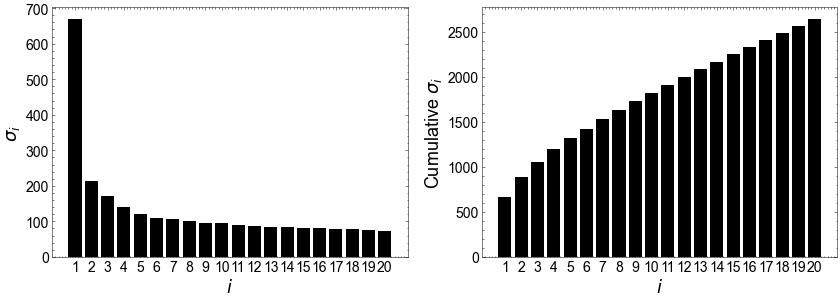

In [8]:
sum_of_sigmas = np.sum(S)
cumsum_of_sigmas = np.cumsum(S)

xticks = []
for num in range(1, 21):
    xticks.append(num)

mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}
    
fig1 = plt.figure(figsize=(12, 4.5))

plt.subplot(1, 2, 1)
plt.bar(np.arange(1, 21), height = S[:20], color='black')
plt.xticks(xticks)
plt.xlabel('$i$', fontsize = 18)
plt.ylabel('$\sigma_i$', fontsize = 18)

plt.subplot(1, 2, 2)
plt.bar(np.arange(1, 21), height = cumsum_of_sigmas[:20], color='black')
plt.xticks(xticks)
plt.xlabel('$i$', fontsize = 18)
plt.ylabel('Cumulative $\sigma_i$', fontsize = 18)

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigma_barchart.pdf')

#### 3D plots of sequences along the first three singular axes

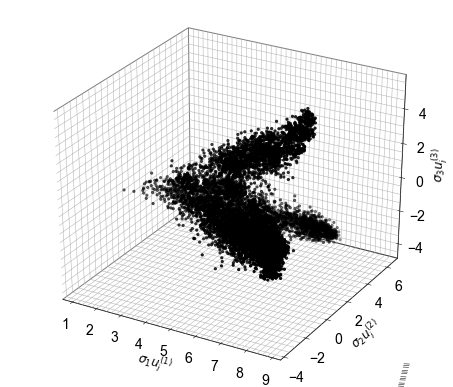

In [9]:
fig4 = plt.figure(1, figsize = (8, 7))
ax = fig4.add_subplot(projection='3d')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

ax.scatter(S[0]*U[:,0], S[1]*U[:,1], S[2]*U[:,2], c = 'black', s = 5)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.view_init(30,300)

## K-Means Clustering

### Elbow plot to Choose Number of Clusters

The WCSS is the sum of squared distance between each point in a cluster and the cluster centroid. We use the elbow method to minimize the WCSS with as few clusters as possible. This is typically found at the "elbow" of the graph. 

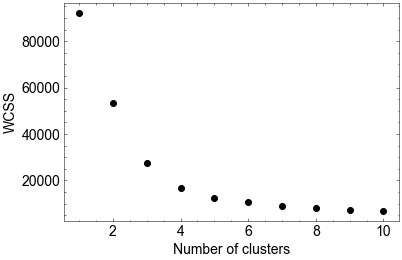

In [10]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

wcss = []

SU_df = pd.DataFrame(S*U[:,:len(S)])

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(SU_df.iloc[:, 0:3])
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(6,4))
plt.plot(range(1, 11), wcss,'o',color='black')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.savefig(f'figures/{PROTEIN_NAME}_elbowplot.pdf')

## Set the number of clusters and define colors


In [11]:
CLUSTERS = 4

cluster_ID_colormap = {0 : 'red', 1 : 'blue', 2: 'orange', 3: 'green', 4: 'black', 5: 'violet'}

## Perform K-Means clustering

In [12]:
kmeans = KMeans(n_clusters = CLUSTERS, init ='k-means++', 
                max_iter = 300, n_init = 10, random_state = 0)
cluster_ID = kmeans.fit_predict(SU_df.iloc[:, 0:3])
cluster_color = [cluster_ID_colormap[k] for k in cluster_ID]

## 2D plots of clustered sequences along the first three singular axes

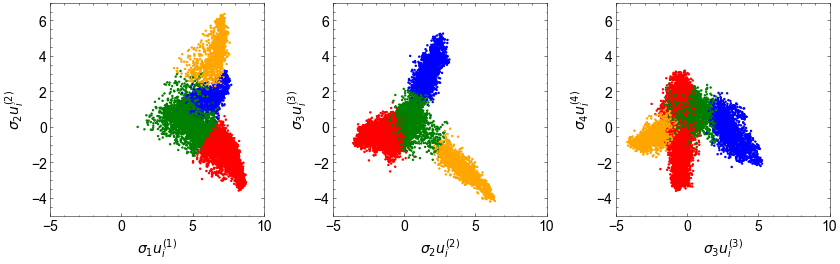

In [13]:
fig2 = plt.figure(figsize=(12,4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlim(-5, 10)
    plt.ylim(-5, 7)
    plt.scatter(S[i]*U[:,i], S[i+1]*U[:,i+1], s = 2, c = cluster_color)
    plt.xlabel(f'$\sigma_{i+1} u_i^{{({i+1})}}$')
    plt.ylabel(f'$\sigma_{i+2} u_i^{{({i+2})}}$')

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigmaU_2dplots_cluster.pdf')

## 3D plot of sequences along the first three singular axes

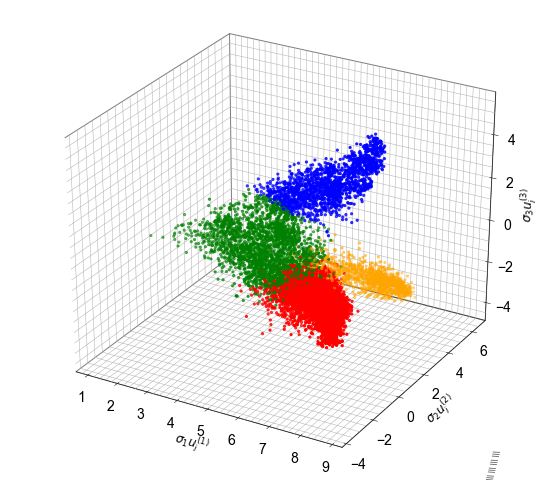

In [14]:
fig6 = plt.figure(1, figsize = (8, 7))
ax = fig6.add_subplot(projection='3d')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

ax.scatter(SU_df[0], SU_df[1], SU_df[2], c = cluster_color, s = 5)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.view_init(30,300)

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigmaU_3dplot_cluster.pdf')

# Create movie of the 3D plot
if MOVIES == 1:
    imagedata = []
    for ii in range(0,360,1):
        # create temporary frame for movie
        ax.view_init(30, azim=ii)
        plt.savefig('movie%d.png' % ii)
        
        # save temporary frame for movie
        data = imageio.imread('movie{}.png'.format(ii))
        data = cv2.resize(data, (960, 960))
        imagedata.append(data)
        
        # remove temporary frame from directory
        os.remove('movie{}.png'.format(ii))

    imageio.mimwrite(f'figures/{PROTEIN_NAME}_sigmaU_3dplot_cluster.mp4', imagedata, format= '.mp4', fps = 20)

## Generate a dictionary of the sequence names (e.g., A0A1J4JHK3/1-112) in each cluster (keyed by color), used for taxonomy analysis

In [15]:
colors = list(cluster_ID_colormap.values())

names_in_color_dict = {c: [] for c in colors[:cluster_ID.max()+1]}

for j in range(len(cluster_ID)):
    label = cluster_ID_colormap[cluster_ID[j]]
    names_in_color_dict[label].append(names[j])

df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in names_in_color_dict.items()]))
df.to_csv(f'figures/{PROTEIN_NAME}_{CLUSTERS}_clusters.csv')

## Generating F-matrices for individual clusters and differences of in-cluster vs. out-of-cluster residue frequencies

The *F_cluster_dict* dictionary below separates the F matrix into an F-matrix for each cluster (e.g., *F_cluster_1*). There is also a residue count for each cluster (e.g., *F_cluster_1_sum*) and a fraction (e.g., *F_cluster_1_fraction*), where the residue count is divided by the number of sequences in each cluster.

In addition, this dictionary contains the same information for sequences *not* in each cluster.

In [18]:
F_cluster_dict = {}
minus_not = {}

for cluster in range(CLUSTERS):
    F_cluster_dict[f'F_cluster_{cluster}'] = np.array([])
    F_cluster_dict[f'F_cluster_{cluster}_sum'] = np.zeros(len(F[0]))
    F_cluster_dict[f'F_not_cluster_{cluster}'] = np.array([])
    F_cluster_dict[f'F_not_cluster_{cluster}_sum'] = np.zeros(len(F[0]))
    
    is_cluster = np.where(cluster_ID == cluster)[0]
    is_not_cluster = np.where(cluster_ID != cluster)[0]
    
    F_cluster_dict[f'F_cluster_{cluster}'] = F[is_cluster]
    F_cluster_dict[f'F_cluster_{cluster}_sum'] = sum(F[is_cluster])
    
    F_cluster_dict[f'F_not_cluster_{cluster}'] = F[is_not_cluster]
    F_cluster_dict[f'F_not_cluster_{cluster}_sum'] = sum(F[is_not_cluster])

    # save frequency of residues in sequences
    F_cluster_dict[f'F_cluster_{cluster}_fraction'] = \
        F_cluster_dict[f'F_cluster_{cluster}_sum']/len(F_cluster_dict[f'F_cluster_{cluster}'])
    
    F_cluster_dict[f'F_not_cluster_{cluster}_fraction'] = \
        F_cluster_dict[f'F_not_cluster_{cluster}_sum']/len(F_cluster_dict[f'F_not_cluster_{cluster}'])

    minus_not[f'{cluster}_minus_not_{cluster}'] = \
        F_cluster_dict[f'F_cluster_{cluster}_fraction'] - F_cluster_dict[f'F_not_cluster_{cluster}_fraction']

## Create lists of residues where in-cluster frequency exceeds out-of-cluster frequency by a specified threshold

In [19]:
# If you want a list of residues depleted in a specifc cluster, uncomment the elif statements.
threshold = 0.4

enriched = {}
depleted = {}
not_enriched = []

for minus, c in zip(minus_not, range(CLUSTERS)):
    enriched[f'{c}_enriched'] = np.where(minus_not[minus] > threshold)[0]
    depleted[f'{c}_depleted'] = np.where(minus_not[minus] < threshold)[0]

all_depleted = [v for k,v in depleted.items()]
not_enriched = all_depleted[all_depleted == CLUSTERS]

for c in range(CLUSTERS):
    num = len(enriched[f'{c}_enriched'])
    print(f'Number of residues enriched in cluster {colors[c]} is {num}')

print(f'Number of residues not enriched in any cluster is {len(not_enriched)}.')

Number of residues enriched in cluster red is 20
Number of residues enriched in cluster blue is 19
Number of residues enriched in cluster orange is 43
Number of residues enriched in cluster green is 0
Number of residues not enriched in any cluster is 3140.


## Collect $v_i^{(k)}$ values for enriched residues in each cluster.

In [20]:
enriched_V = {}

V_len = len(V.transpose())

for c in range(CLUSTERS):
    enriched_V[f'{c}_enriched_V'] = np.zeros((len(enriched[f'{c}_enriched']), V_len))
    enriched_V[f'{c}_enriched_V'] = V[enriched[f'{c}_enriched'], :]

not_enriched_V = np.zeros((len(not_enriched), len(V.transpose())))
not_enriched_V = V[not_enriched, :]

### Plot $v_i^{(k)}$ values for enriched and not-enriched residues.

#### 3D plot of cluster-enriched $v_i^{(k)}$ values along the first three singular axes

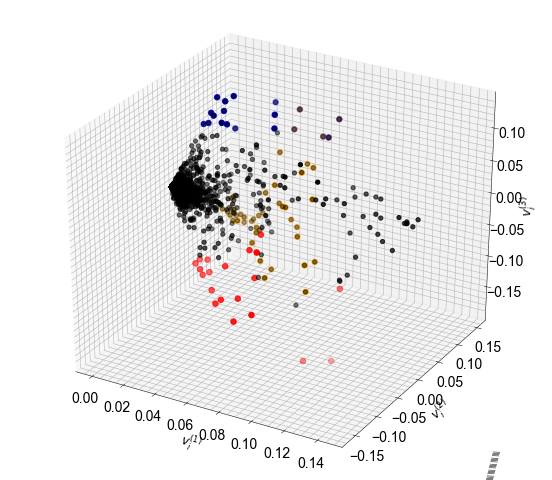

In [21]:
fig = plt.figure(1, figsize = (8, 7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel(f"$v_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$v_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$v_i^{{({3})}}$", fontsize=12)


ax.scatter(not_enriched_V[:, 0], not_enriched_V[:, 1], not_enriched_V[:, 2], c = 'k', s = 18)

for c in range(CLUSTERS):
    ax.scatter(enriched_V[f'{c}_enriched_V'][:, 0], 
               enriched_V[f'{c}_enriched_V'][:, 1], 
               enriched_V[f'{c}_enriched_V'][:, 2], c = colors[c], s = 30)

ax.view_init(30,300)
plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_V_enriched_3dplot.pdf')

# Create movie of the 3D plot
if MOVIES == 1:
    imagedata = []
    for ii in range(0,360,1):
        # create temporary frame for movie
        ax.view_init(30, azim=ii)
        plt.savefig('movie%d.png' % ii)
        
        # save temporary frame for movie
        data = imageio.imread('movie{}.png'.format(ii))
        data = cv2.resize(data, (960, 960))
        imagedata.append(data)
        
        # remove temporary frame from directory
        os.remove('movie{}.png'.format(ii))

    imageio.mimwrite(f'figures/{PROTEIN_NAME}_V_enriched_3dplot.mp4', imagedata, format= '.mp4', fps = 20)

#### 2D plot of cluster-enriched $v_i^{(k)}$ values along the first four singular axes

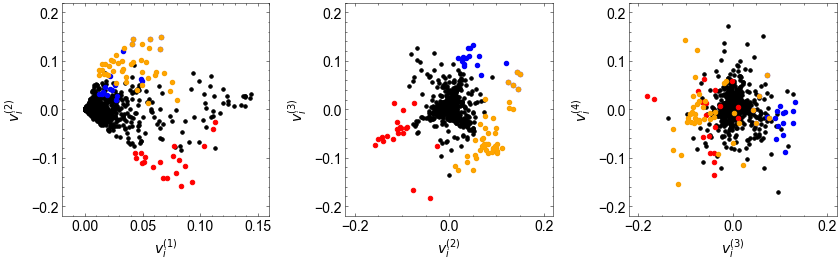

In [22]:
fig = plt.figure(figsize=(12,4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    if i == 0:
        plt.xlim(-0.02, 0.16)
    else:
        plt.xlim(-0.22, 0.22)
    plt.ylim(-0.22, 0.22)
    plt.scatter(not_enriched_V[:, i], not_enriched_V[:, i+1], c = 'k', s = 12)
    for c in range(CLUSTERS):
        plt.scatter(enriched_V[f'{c}_enriched_V'][:, i], 
                   enriched_V[f'{c}_enriched_V'][:, i+1], c = colors[c], s = 20)
    
    plt.xlabel(f"$v_i^{{({i+1})}}$")
    plt.ylabel(f"$v_i^{{({i+2})}}$")

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_V_enriched_2dplots.pdf')